# Google Ngram Language Model
* DNSC 6290 Working with Large Data Set 
* Group Members: Hailey Ling, Tianwei Ma, Sophie Song, Liping Xie


### 1. Data Import

In [1]:
import findspark
findspark.init()
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

sc=SparkContext()
spark = SparkSession.builder.getOrCreate()

In [2]:
one_gram = spark.sparkContext.sequenceFile('s3://datasets.elasticmapreduce/ngrams/books/20090715/eng-gb-all/1gram/data')

In [3]:
one_gram.take(5)

[(1, '#\t1547\t1\t1\t1'),
 (2, '#\t1551\t1\t1\t1'),
 (3, '#\t1596\t6\t6\t1'),
 (4, '#\t1597\t9\t8\t2'),
 (5, '#\t1598\t2\t2\t2')]

### 2. Pre-processing

Split raw text by `\t` delimiter and only return words and occurance

In [4]:
import string
import sys
import os,datetime, re
from pyspark.sql import Row
from pyspark.sql.types import *

In [5]:
def process_data(tp):
    (num, line) = tp
    word, y, n1, n2, n3 = re.split(r'[\t]', line)
    # replace punctuations
    if word in string.punctuation:
        word='punctuation'
    return (word,int(n1)) 

In [6]:
rdd_basic = one_gram.map(lambda ls: process_data(ls))
rdd_basic.take(10)

[('punctuation', 1),
 ('punctuation', 1),
 ('punctuation', 6),
 ('punctuation', 9),
 ('punctuation', 2),
 ('punctuation', 2),
 ('punctuation', 4),
 ('punctuation', 3),
 ('punctuation', 8),
 ('punctuation', 1)]

this is the result after replacing punctuations with word `punctuation`. Only keep words and their occurance for ploting word cloud.

### 3. Word Cloud

Using word cloud to show words with highest occurance.

In [7]:
!pip install wordcloud

     |████████████████████████████████| 364 kB 21.6 MB/s eta 0:00:01


In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [8]:
def add(a,b):
    return a+b

# calculate total occurance across years and sort descending
sort_rdd = rdd_basic.reduceByKey(add).sortBy(lambda x:x[1], ascending=False)

In [9]:
sort_rdd.take(10)

[('punctuation', 8042169654),
 ('the', 2608616794),
 ('of', 1745660178),
 ('and', 1238384271),
 ('to', 1056820835),
 ('in', 830935738),
 ('a', 758436608),
 ('is', 445449644),
 ('that', 425676641),
 ('was', 320008452)]

In [10]:
# remove punctuation and extract top 1000 words
df_1000 = sort_rdd.take(1001)
df_1000 = df_1000[1:]

# create dict for word cloud
dicta = {}
for i in df_1000:
    dicta[i[0]]=i[1]

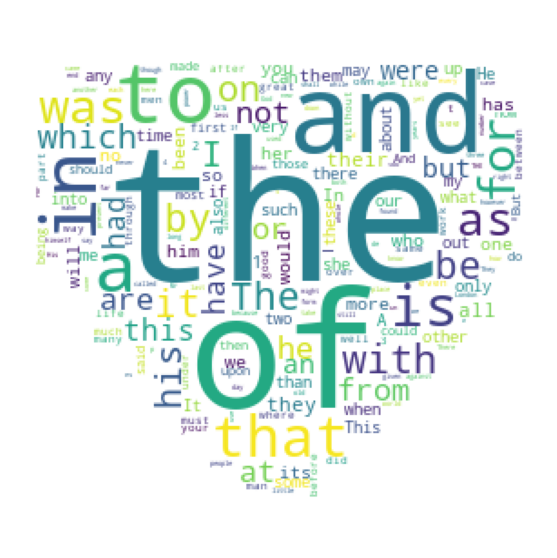

In [11]:
# draw word cloud
plt.figure(figsize=(10, 10)) 
image = Image.open('heart.jpg')
graph = np.array(image)
wc = WordCloud(background_color='white',mask=graph)
wc.generate_from_frequencies(dicta)
plt.imshow(wc)
plt.axis('off')
plt.show()

The word cloud result is in accordance with our hypothesis that the most frequent words are prepositions. Words `the`, `of` and `and` are the top 3 popular words across our 1-gram data set.

### 4. Viewer

Trend viewer is the plot of occurrence frequency for some words in chronicle order. 

In [12]:
import csv
import nltk
import collections
from nltk.stem.wordnet import WordNetLemmatizer

In [13]:
def count_in_a_partition(idx, iterator):
    count = 0
    for _ in iterator:
        count += 1
    return idx, count

def keeper_func(x,int_words):
    out = []
    if len(x) != 2:
        out = []
    else:
        sep = x[1].split('\t')
        if len(sep) != 5:
            out = []
        else:
            try:
                word = sep[0].lower()
                if word in int_words:
                    out.append(word)
                    for item in sep[1:]:
                        out.append(item)
            except:
                pass
    final_out=[]
    if len(out) == 5:
        final_out = out
    return tuple(final_out) # VERY IMPORTANT!!

def occurrence_ratio(x,THR):
    oc_dict = {}
    values = x[1]
    for item in values:
        if item[0] not in oc_dict.keys():
            oc_dict[item[0]] = (int(item[1]), int(item[2]))
        else:
            oc_dict[item[0]] = (oc_dict[item[0]][0]+int(item[1]), oc_dict[item[0]][1]+int(item[2]))
    out = []
    total_value = 0
    for key in oc_dict.keys():
        value = float(oc_dict[key][0])/float(oc_dict[key][1])
        total_value = total_value + value
        out.append((key,value))
    # Consider only words that have interesting occur ratio
    out_final = []
    if total_value/len(out) >= THR:
        out_final = out
    return out_final

def reorder_plot(data,color,plt):
    dc = dict()

    for item in data:
        if item[0] not in dc.keys():
            dc[item[0]] = (int(item[1]),int(item[2]))
        else:
            dc[item[0]] = (dc[item[0]][0]+int(item[0]),dc[item[0]][1]+int(item[2]))
    od_dc = collections.OrderedDict(sorted(dc.items()))
    # Re-order to plot
    year = np.empty([len(od_dc), 1])
    occu_ratio = np.empty([len(od_dc), 1])
    for i,key in enumerate(od_dc.keys()):
        year[i,0] = int(key)
        occu_ratio[i,0] = float(od_dc[key][0])/float(od_dc[key][1])
    plt.plot(year,occu_ratio,color)
    return plt

In [14]:
# Interesting words
int_words = ['globalization', 'capitalism', 'war','nuclear','love','hope','peace','inequality','poverty','chaos','violence','expressionism','dadaism']

#Keep only data from your int_words
rdd3 = one_gram.map(lambda x: keeper_func(x,int_words)).filter(lambda x: x).cache()

# Super important, transforms tuples into key pairs.
rdd4 = rdd3.map(lambda x : (x[0], x[1:]))

# Group Everything By Key
total_data = rdd4.groupByKey().map(lambda x : (x[0], list(x[1]))).collect()

/home/hadoop/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


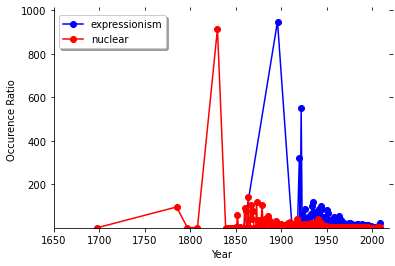

In [15]:
color = ['-ob','-or','-og','-ok','-oy']
names = []
c = 0

for i,item in enumerate(total_data):
    data = []
    if item[0] in ['nuclear', 'expressionism']:
        names.append(item[0])
        for algo in item[1]:
            values = algo[0:]
            data.append(values)
        plt = reorder_plot(data,color[c],plt)
        c+=1

ax = plt.subplot(111)
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.xlabel('Year')
plt.ylabel('Occurence Ratio')
plt.legend(names,shadow=True)
plt.ylim(ymin=.5,ymax=1000)
plt.xlim(xmin=1650,xmax=2018)
plt.tick_params(top='off', right='off')

plt.show()


The trend viewer is designed to examine a word’s average popularity and its first occurrence. For the example above, the word “nuclear” was first introduced around 1700 and began widely discussed in the 19th and 20th centuries. Similarly, the word “expressionism” began popular in the 20th century. 


### 5. Language Model
Language modeling is the task of predicting what word comes next or more generally.  
This model is based on the Markov assumption, which means we approximate the probability of a specific word by looking only at the last several words of the context.  
#### 5.1 Data Import

We're going to try text generation using 3-gram set. A 3-gram language model predicts the probability of a given 3-gram within any sequence of words in the language. 

In [16]:
# dataset of British English 3-gram (46.8GB)
trigram = spark.sparkContext.sequenceFile('s3://datasets.elasticmapreduce/ngrams/books/20090715/eng-gb-all/3gram/data')

# check first several rows
trigram.take(5)

[(1, '! ! That\t1791\t1\t1\t1'),
 (2, '! ! That\t1804\t2\t2\t1'),
 (3, '! ! That\t1810\t2\t2\t2'),
 (4, '! ! That\t1815\t1\t1\t1'),
 (5, '! ! That\t1819\t1\t1\t1')]

#### 5.2 Data Cleaning

In [17]:
# function for words and occurance extraction
def split_tp(tp):
    
    # extract every single word and the frequency of words combination
    (index, line) = tp
    tri_gram, y, n1, n2, n3 = re.split(r'[\t]',line)
    words = tri_gram.split()
    #split '"' with other character
    if len(words)<3:
        words_lst=[]
        for word in words:
            if '"' in word:
                index = word.find('"')
                if index==0:
                    word1='"'
                    word2=word[1:]
                else:
                    word1=word[:index]
                    word2='"'
                words_lst.append(word1)
                words_lst.append(word2)
            else:
                words_lst.append(word)
    else:
        words_lst=words
        
    #avoid errors caused by irregular words combination 
    while len(words_lst)<3:
        words_lst.append('Null')   
    match_count=int(n1)
    
    return (words_lst[0],words_lst[1],words_lst[2]), match_count 

In [18]:
new_gram = trigram.map(lambda ls: split_tp(ls))

#review the first 10 rows of our new data
new_gram.take(10)

[(('!', '!', 'That'), 1),
 (('!', '!', 'That'), 2),
 (('!', '!', 'That'), 2),
 (('!', '!', 'That'), 1),
 (('!', '!', 'That'), 1),
 (('!', '!', 'That'), 1),
 (('!', '!', 'That'), 6),
 (('!', '!', 'That'), 1),
 (('!', '!', 'That'), 1),
 (('!', '!', 'That'), 3)]

In [19]:
# Calculate the total frequency for every words combination during all year
reduced_rdd = new_gram.reduceByKey(add).cache()
reduced_rdd.take(20)

[(('stentorian', 'tones', '.'), 222),
 (('"', 'stepson', 'Null'), 2657),
 (('stiffly', ')', ':'), 246),
 (('still', 'a', 'stubborn'), 47),
 (('still', 'as', 'wither'), 42),
 (('still', 'only', 'known'), 95),
 (('still', 'surprised', 'at'), 198),
 (('still', 'the', 'national'), 279),
 (('stimulates', 'antibody', 'production'), 61),
 (('stimulation', '.', 'Br'), 52),
 (('"', 'stipulated', 'Null'), 12022),
 (('stories', 'and', 'lies'), 60),
 (('storm', 'in', 'its'), 300),
 (('storms', 'of', 'snow'), 603),
 (('story', 'and', 'even'), 157),
 (('story', 'of', 'military'), 159),
 (('strain', 'with', 'which'), 356),
 (('"', 'strange', 'adventure'), 1058),
 (('streak', 'of', 'it'), 82),
 (('street', 'I', 'noticed'), 80)]

In [20]:
# Transform tuples to rows preparing for building dataframe
def Rowtransfer(element):
    words, value = element
    wd1, wd2, wd3 = words
    return Row(word_12= wd1+' '+wd2, word_3=wd3, 
               count=value)

In [22]:
rdd = reduced_rdd.map(Rowtransfer)
rdd.take(10)

[Row(count=222, word_12='stentorian tones', word_3='.'),
 Row(count=2657, word_12='" stepson', word_3='Null'),
 Row(count=246, word_12='stiffly )', word_3=':'),
 Row(count=47, word_12='still a', word_3='stubborn'),
 Row(count=42, word_12='still as', word_3='wither'),
 Row(count=95, word_12='still only', word_3='known'),
 Row(count=198, word_12='still surprised', word_3='at'),
 Row(count=279, word_12='still the', word_3='national'),
 Row(count=61, word_12='stimulates antibody', word_3='production'),
 Row(count=52, word_12='stimulation .', word_3='Br')]

In [23]:
# Transform rdd to DataFrame
wd_df = spark.createDataFrame(rdd)

wd_df.show(20)

+-----+-------------------+----------+
|count|            word_12|    word_3|
+-----+-------------------+----------+
|  222|   stentorian tones|         .|
| 2657|          " stepson|      Null|
|  246|          stiffly )|         :|
|   47|            still a|  stubborn|
|   42|           still as|    wither|
|   95|         still only|     known|
|  198|    still surprised|        at|
|  279|          still the|  national|
|   61|stimulates antibody|production|
|   52|      stimulation .|        Br|
|12022|       " stipulated|      Null|
|   60|        stories and|      lies|
|  300|           storm in|       its|
|  603|          storms of|      snow|
|  157|          story and|      even|
|  159|           story of|  military|
|  356|        strain with|     which|
| 1058|          " strange| adventure|
|   82|          streak of|        it|
|   80|           street I|   noticed|
+-----+-------------------+----------+
only showing top 20 rows



In [24]:
df_sql = wd_df.createOrReplaceTempView('df_sql')
df_sql = spark.sql("CACHE TABLE df_sql")

df_null = spark.sql('select * from df_sql where word_3="Null"')
df_null.show()

+-------+----------------+------+
|  count|         word_12|word_3|
+-------+----------------+------+
|   2657|       " stepson|  Null|
|  12022|    " stipulated|  Null|
| 193156|      " struggle|  Null|
|  20193|     " sufferers|  Null|
|  40906|     " synthesis|  Null|
|  11803|" systematically|  Null|
|    340|           " tam|  Null|
|  27347|    " terminated|  Null|
|   7077|        " thrall|  Null|
|   1502|        " thynge|  Null|
|9097488|          " time|  Null|
|  48274|        " tithes|  Null|
|  49555|         " trick|  Null|
|  10472| " uncertainties|  Null|
|  13460|     " unhealthy|  Null|
|  72376|         " vices|  Null|
|  78794|       " victims|  Null|
|  17480|           " vie|  Null|
|   3506|         " vifit|  Null|
|  56669|           " vii|  Null|
+-------+----------------+------+
only showing top 20 rows



There are still some irregular data, which means: the third word is "Null"

In [25]:
df_null.count()

235654

In [26]:
df_sql_all = spark.sql('select * from df_sql')
df_sql_all.count()

72744735

In [27]:
(df_sql_all.count()-df_null.count())/df_sql_all.count()

0.9967605353157174

The remained data reach to the 99.68% of the original data, so removing the irregular data will not exert significant effect to our model

#### 5.3 Model Building

Remove unregular data and calculate the probability: the frequency of a three-words combination/the frequency of the first two-words combination

In [28]:
df_count = spark.sql('with cte as\
                         (select word_12,word_3, \
                         count,sum(count) over (partition by word_12) as total_count \
                         from df_sql\
                         where word_3!="Null")\
                     select word_12,word_3, count/total_count as probability from cte\
                     order by word_12, probability desc')
df_count.show()

+-------+------+--------------------+
|word_12|word_3|         probability|
+-------+------+--------------------+
|    ! !|     !|  0.3469251002630342|
|    ! !|     '| 0.06572854471081241|
|    ! !|     .| 0.06372828467700802|
|    ! !|     )|  0.0459259703761489|
|    ! !|     I| 0.03392441017332253|
|    ! !|   The|0.028523708082050667|
|    ! !|     (|0.022542930580975527|
|    ! !|   and| 0.01760228829747867|
|    ! !|    of|0.014631902147279146|
|    ! !|   the| 0.01145148869353016|
|    ! !|    It|0.010401352175782851|
|    ! !|   And|0.009621250762599138|
|    ! !|   But|0.008701131147049117|
|    ! !|  This|0.008301079140288237|
|    ! !|     A|0.008131057037414863|
|    ! !|     -|0.007520977727104523|
|    ! !|    We|0.006870893216118095|
|    ! !|    He|0.006850890615780051|
|    ! !|     *|0.006580855511216458|
|    ! !|    In|0.006570854211047437|
+-------+------+--------------------+
only showing top 20 rows



In [29]:
# Formally build the database for our model
df_model = df_count.createOrReplaceTempView('model')
df_model = spark.sql("CACHE TABLE model")

# test df_model
df1 = spark.sql("select * from model where word_12 = 'I am'")

df1.show()

+-------+---------+--------------------+
|word_12|   word_3|         probability|
+-------+---------+--------------------+
|   I am|      not| 0.09659228248056738|
|   I am|     sure| 0.04816873417215208|
|   I am|        a| 0.03582667933025214|
|   I am|   afraid|0.021979895643062568|
|   I am|     very|0.021506266043526238|
|   I am|      the|0.021107614072265572|
|   I am|       in|0.019769075179189473|
|   I am|    going|0.019073257691677246|
|   I am|     glad| 0.01893294913834549|
|   I am|    sorry|0.017583116543939164|
|   I am|      now|0.017302421008794186|
|   I am|       to|0.016348024817908674|
|   I am|        .|0.012685493162212845|
|   I am|       so|0.012609652820641122|
|   I am|     told|0.010630510091000567|
|   I am|    quite|0.009766306653793938|
|   I am|convinced|0.008903514929253589|
|   I am|       no| 0.00879316605583951|
|   I am|       of|0.008537489206280238|
|   I am| indebted|0.007908179071046009|
+-------+---------+--------------------+
only showing top

In [106]:
import random

# The first two words in 3-grams were given as “I am”
words = ['I', 'am']
sentence_finished = False
while not sentence_finished:
    r = random.uniform(0.005,0.045)
    if "'" in words[-2:]:
        a = spark.sql('select * from model where word_12="%s%s%s" and probability>%s'%(words[-2],' ',words[-1],r))
    else:
        a = spark.sql("select * from model where word_12 = '%s%s%s' and probability>%s" %(words[-2],' ',words[-1],r))        
    if a.count() != 0:
        words.append(a.rdd.takeSample(False,1)[0][1])
    else:
        words.append(None)
        
    if words[-2:]==[None, None]:
        sentence_finished=True

print(' '.join([t for t in words if t]))

I am now convinced that he had been a of this kind are not


#### 5.4 Model Explanation

The output resembles an actual sentence for the first half, but as it stretches out it will become irrelevant to the first half of the sentence. Because the model is based on 3-grams, it will have the highest predictability for the first 3 to 4 words.

In [107]:
sc.stop()
spark.stop()